In [14]:
# Number of Instances: 67557
stone_AI = -1.0
stone_HUMAN = 1.0

target_AIloss = 0.0
target_AIdraw = 0.5
target_AIwin = 1.0 # opp loss, AI win

import pandas as pd
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torch.nn as nn
import random
import math

device = torch.device('cuda:0')

In [15]:

data = pd.read_csv('connect-4.data', header=None)

y = pd.DataFrame(data.iloc[:, 42])
data.drop(columns=[42], inplace=True)

data[data == 'b'] = 0.0
data[data == 'o'] = stone_HUMAN
data[data == 'x'] = stone_AI
y[y == 'win'] = target_AIwin
y[y == 'loss'] = target_AIloss
y[y == 'draw'] = target_AIdraw

data = data.astype(float)
#data = torch.tensor(data.to_numpy())
y = y.astype(float)
#y = torch.tensor(y.to_numpy())


#split out validation
data = data.to_numpy()
train_X = data[ : math.floor(len(data) * 0.85), : ]
valid_X = data[math.floor(len(data) * 0.85): , : ]
y = y.to_numpy()
train_Y = y[ : math.floor(len(y) * 0.85), : ]
valid_Y = y[math.floor(len(y) * 0.85): , : ]

print(train_X.shape, train_Y.shape, valid_X.shape, valid_Y.shape)

(57423, 42) (57423, 1) (10134, 42) (10134, 1)


In [16]:

class Model(nn.Module):
    def __init__(self, in_1=42, out_1=40, out_2=1):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features=in_1, out_features=out_1, bias=True)
        self.ac1 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=out_1, out_features=out_2, bias=True)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x
'''
class Model(nn.Module):
    def __init__(self, in_1=42, out_1=20, out_2=10, out_3=10, out_4=1):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features=in_1, out_features=out_1, bias=True)
        self.ac1 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=out_1, out_features=out_2, bias=True)
        self.ac2 = nn.ReLU()
        self.fc3 = nn.Linear(in_features=out_2, out_features=out_3, bias=True)
        self.ac3 = nn.ReLU()
        self.fc4 = nn.Linear(in_features=out_3, out_features=out_4, bias=True)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        x = self.fc4(x)
        return x
'''

class Dataset_train(Dataset):
    def __init__(self):
        self.X = train_X
        self.Y = train_Y
        self.len = len(train_X)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

class Dataset_valid(Dataset):
    def __init__(self):
        self.X = valid_X
        self.Y = valid_Y
        self.len = len(valid_X)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


epoch = 0
validation set loss: 0.6059817671775818
epoch = 1
validation set loss: 0.33903536200523376
epoch = 2
validation set loss: 0.20285481214523315
epoch = 3
validation set loss: 0.15670256316661835
epoch = 4
validation set loss: 0.14532431960105896
epoch = 5
validation set loss: 0.1411353498697281
epoch = 6
validation set loss: 0.13890273869037628
epoch = 7
validation set loss: 0.13710646331310272
epoch = 8
validation set loss: 0.1355181634426117
epoch = 9
validation set loss: 0.13425913453102112
epoch = 10
validation set loss: 0.13302923738956451
epoch = 11
validation set loss: 0.13217782974243164
epoch = 12
validation set loss: 0.1312074363231659
epoch = 13
validation set loss: 0.13080859184265137
epoch = 14
validation set loss: 0.130699023604393
epoch = 15
validation set loss: 0.1309485286474228


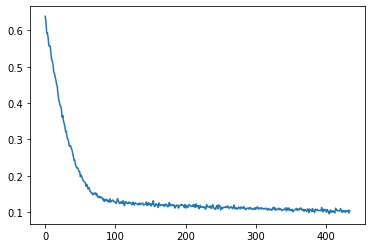

In [17]:
model = Model()
model.to(device)
model.train()

dataset_train = Dataset_train()
dataloader_train = DataLoader(dataset=dataset_train, batch_size=2000, shuffle=True)
dataset_valid = Dataset_valid()
dataloader_valid = DataLoader(dataset=dataset_valid, batch_size=len(dataset_valid), shuffle=True)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# train_X.shape, train_Y.shape, valid_X.shape, valid_Y.shape


n_epochs = 60
loss_list = []
last_vloss = 100000


for epoch in range(n_epochs):
    print("epoch =", epoch)

    for vx, vy in dataloader_valid:
        vx, vy = vx.to(device), vy.to(device)
        vx = vx.to(torch.float32)
        vy = vy.to(torch.float32)
        vyhat = model(vx)
        vyhat = vyhat.to(torch.float32)
        vloss = criterion(vyhat, vy)
        print("validation set loss:", vloss.item())

    if vloss >= last_vloss:
        break
    else:
        last_vloss = vloss

    for x, y in dataloader_train:
        x, y = x.to(device), y.to(device)
        x = x.to(torch.float32)
        y = y.to(torch.float32)

        optimizer.zero_grad()
        yhat = model(x)
        yhat = yhat.to(torch.float32)

        loss = criterion(yhat, y)
        loss.backward()
        optimizer.step()
        loss_list.append(loss)
    


plt.plot(loss_list)
plt.show()



In [18]:
layer1_w = model.state_dict()['fc1.weight'].cpu().numpy()
layer1_b = model.state_dict()['fc1.bias'].cpu().numpy()
layer2_w = model.state_dict()['fc2.weight'].cpu().numpy()
layer2_b = model.state_dict()['fc2.bias'].cpu().numpy()
print(layer1_w, layer1_w.shape)
print(layer1_b, layer1_b.shape)
print(layer2_w, layer2_w.shape)
print(layer2_b, layer2_b.shape)
#np.savetxt("layer1_w.csv", layer1_w, delimiter=",")
#np.savetxt("layer1_b.csv", layer1_b, delimiter=",")
#np.savetxt("layer2_w.csv", layer2_w, delimiter=",")
#np.savetxt("layer2_b.csv", layer2_b, delimiter=",")

[[-0.15149225 -0.10427672 -0.1299126  ... -0.02341947 -0.02549197
   0.01410403]
 [-0.10435499 -0.17389831 -0.05878425 ...  0.11395543  0.18650234
   0.15343344]
 [-0.05783638 -0.15958585  0.17615779 ... -0.15323055 -0.06199133
   0.00329117]
 ...
 [-0.22692691 -0.08385538 -0.05621172 ...  0.02846722 -0.19720915
  -0.06415504]
 [ 0.13756828  0.13737805  0.13588928 ...  0.09543657  0.00810291
   0.23308508]
 [ 0.11549523  0.12210504  0.08045959 ...  0.08273717  0.11535321
   0.11469609]] (40, 42)
[ 0.02501527  0.04276742  0.05867738 -0.03504275 -0.1678042  -0.09522022
 -0.02732091 -0.03374884  0.02910201 -0.1245258   0.1437497   0.00359501
  0.03078731  0.11080275 -0.02388015  0.09901504  0.11001408  0.22753751
 -0.02701098 -0.00984535  0.02461523  0.07891425  0.14678016  0.05196284
  0.02462163  0.16079174 -0.1312745   0.04329848 -0.00186471  0.05831247
 -0.02556045  0.14389321  0.1705667   0.08389808 -0.04746745 -0.17156579
 -0.0451755   0.06981488  0.12212144 -0.13324112] (40,)
[[-0.

In [19]:
total_params = sum(p.numel() for p in model.parameters())
total_params

1761